## Loading of Stringer orientations data

includes some visualizations

In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_orientations.npy"
url = "https://osf.io/ny4ut/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_orientations.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


dat has fields:
* `dat['sresp']`: neurons by stimuli, a.k.a. the neural response data (23589 by 4598)
* `dat['xyz']`: three-dimensional position of each neuron in the brain. 
* `dat['run']`: 1 by stimuli, a.k.a. the running speed of the animal in a.u.
* `dat['istim']`: 1 by stimuli, goes from 0 to 2*np.pi, the orientations shown on each trial
* `dat['u_spont']`: neurons by 128, the weights for the top 128 principal components of spontaneous activity. Unit norm.
* `dat['v_spont']`: 128 by 910, the timecourses for the top 128 PCs of spont activity.
* `dat['u_spont'] @ dat['v_spont']`: a reconstruction of the spontaneous activity for 910 timepoints interspersed throughout the recording.
* `dat['stat']`: 1 by neurons, some statistics for each neuron, see Suite2p for full documentation.


In [4]:
# Mind readers analysis - LDA

![alt text](https://sebastianraschka.com/images/blog/2014/linear-discriminant-analysis/lda_1.png)

See: [Linear Discriminant Analysis](https://sebastianraschka.com/images/blog/2014/linear-discriminant-analysis/lda_1.png)

In [5]:
#Classification with Linear discriminant analysis for orientation in V1
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import sklearn.model_selection
import scipy.stats

train_size = 0.7 #use 70% of the data for training
rng = np.random.RandomState(0) #define random number generator

clf = LDA() #define LDA

n = 10 #number of categories to distingush
spanistim = 2 * np.pi / n 
labelsistim = dat["istim"] // spanistim # splits the data in n categories (whole numbers)
sresp = dat['sresp'].T #read out the neuronal activity for each neuron

print(np.unique(labelsistim)) #show the labels





[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [6]:
#Split the data into test and training sets
X_trainistim, X_testistim, y_trainistim, y_testistim = sklearn.model_selection.train_test_split(dat['sresp'].T, labelsistim, train_size=train_size, random_state=rng)
#Calculate z-score to make neuronal activity comparable
Z_trainistim = scipy.stats.zscore(X_trainistim, axis=1)
Z_testistim = scipy.stats.zscore(X_testistim, axis=1)

In [7]:
clf.fit(Z_trainistim, y_trainistim)
#LDA(n_components=None, priors=None, shrinkage=None, solver='svd',
#  store_covariance=False, tol=0.0001) #used inputs for LDA()

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [8]:
y_predistim = clf.predict(Z_testistim) #Predict classes for test set

#plt.scatter(y_test, y_pred) #Scatter plot between real and predicted input

In [9]:
#Plot predictions vs. real class as confusion matrix
from sklearn.metrics import confusion_matrix
confistim = confusion_matrix(y_testistim, y_predistim)
print(confistim)

[[112   3   0   0   0   0   0   0   0   2]
 [  4 137   4   0   0   0   0   0   0   0]
 [  0   4 136   0   0   0   0   0   0   0]
 [  0   0   4 143   0   0   0   0   0   1]
 [  0   0   0   3 126   3   0   0   0   1]
 [  2   0   0   0   4 136   3   0   0   0]
 [  0   1   0   0   0   4 131   1   0   0]
 [  0   0   0   0   0   0   1 132   5   0]
 [  0   0   0   0   0   0   0   3 124   8]
 [  5   0   0   0   1   0   0   0   3 133]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


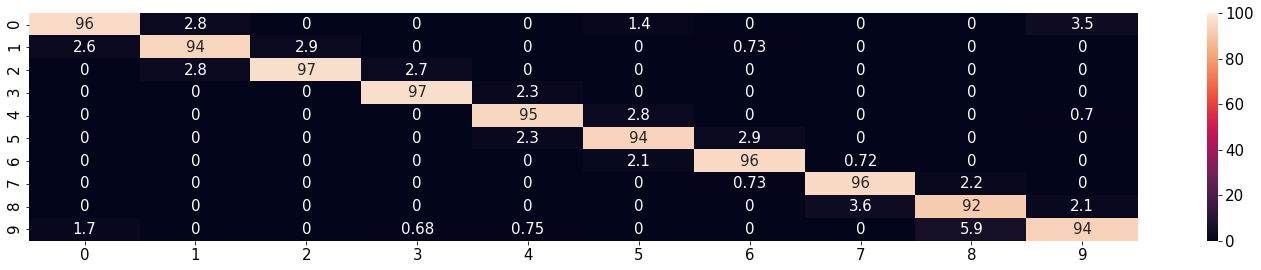

In [10]:
#For nicer presentation, use a heatplot to show percentage correct for each class
import seaborn as sn

uniqueistim, countsistim = np.unique(y_testistim, return_counts=True) #Find out how often each class is present in y_test

countsmatrixistim = (np.repeat(countsistim,(n))) #Matrix of number of trials per condition
countsmatrixistim = np.reshape(countsmatrixistim,(n,n))

conf2istim = confistim / countsmatrixistim * 100 #Calculate percentage correct

axistim=sn.heatmap(conf2istim.T, 0,100,annot=True) #Plot the heatmap

In [11]:
print(dat['run'].shape)
print(np.min(dat['run']))
print(np.max(dat['run']))

(4598,)
0.0
80.61597


In [12]:
#Try to classify running speed from neuronal acitivy in V1
#(This is basically the same as before just with run instead of istim)

import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import sklearn.model_selection
import scipy.stats

train_size = 0.7 #use 70% of the data for training
rng = np.random.RandomState(0) #define random number generator

clf = LDA() #define LDA

n = 10 #number of categories to distingush
spanrun = 80.61597 / n 
labelsrun = dat["run"] // spanrun # splits the data in n categories (whole numbers)
sresp = dat['sresp'].T #read out the neuronal activity for each neuron

print(np.unique(labelsrun)) #show the labels

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [13]:
#Split the data into test and training sets
X_trainrun, X_testrun, y_trainrun, y_testrun = sklearn.model_selection.train_test_split(dat['sresp'].T, labelsrun, train_size=train_size, random_state=rng)
#Calculate z-score to make neuronal activity comparable
Z_trainrun = scipy.stats.zscore(X_trainrun, axis=1)
Z_testrun = scipy.stats.zscore(X_testrun, axis=1)

In [14]:
clf.fit(Z_trainrun, y_trainrun)
#LDA(n_components=None, priors=None, shrinkage=None, solver='svd',
#  store_covariance=False, tol=0.0001) #used inputs for LDA()

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [15]:
y_predrun = clf.predict(Z_testrun) #Predict classes for test set

#plt.scatter(y_test, y_pred) #Scatter plot between real and predicted input

In [18]:
#Plot predictions vs. real class as confusion matrix
from sklearn.metrics import confusion_matrix
confrun = confusion_matrix(y_testrun, y_predrun)
print(confrun.T)

[[869  53   7   0   0   0   0   0   0   0]
 [ 25  44  20  13   3   3   0   0   0   0]
 [  2  10  11  10   2   2   0   0   0   0]
 [  0   6   9  12   7   6   4   1   0   0]
 [  2   3   4  11   9   5  10   4   0   0]
 [  0   0   2   7  19  30  25  13   2   0]
 [  0   0   1   5  14  18  28  12  10   1]
 [  1   0   0   2   2   4   9   1   0   3]
 [  0   0   0   1   0   2   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


[899 116  54  61  56  70  77  31  12   4]


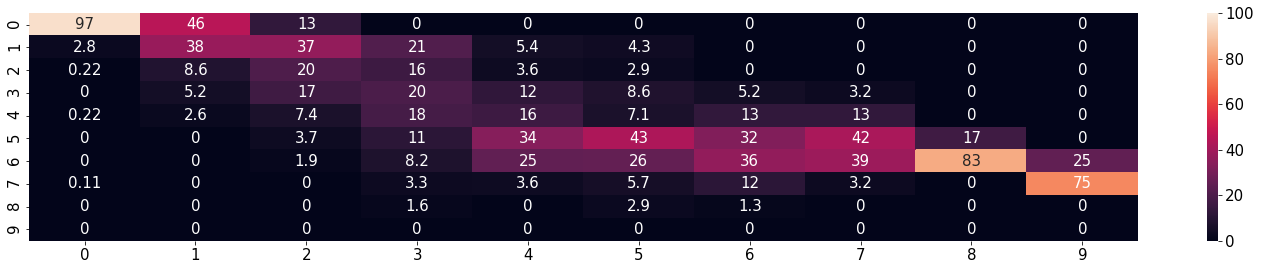

In [19]:
#For nicer presentation, use a heatplot to show percentage correct for each class
import seaborn as sn

uniquerun, countsrun = np.unique(y_testrun, return_counts=True) #Find out how often each class is present in y_test
print(countsrun)

countsmatrixrun = (np.repeat(countsrun,(n))) #Matrix of number of trials per condition
countsmatrixrun = np.reshape(countsmatrixrun,(n,n))

conf2run = confrun / countsmatrixrun * 100 #Calculate percentage correct

ax=sn.heatmap(conf2run.T, 0,100,annot=True) #Plot the heatmap

In [22]:
uniquerun, countsrun = np.unique(dat['run'], return_counts=True) #Find out how often each class is present in y_test
print(uniquerun)
print(countsrun)
print(len(countsrun))

[0.0000000e+00 8.0301356e-07 1.3383559e-06 ... 7.5989861e+01 7.7829803e+01
 8.0615967e+01]
[1399    1    1 ...    1    1    1]
3198
